In [1]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt

In [2]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [3]:
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.mnist.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.mnist.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4,4), stride=2)# 28x28 -> 24/2+1x24/2+1
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3),stride=2)# 13x13 -> 10/2+1x10/2+1
        self.fc1 = nn.Linear(6*6*32, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(-1, 6*6*32)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = self.softplus(self.fc22(hidden))
        return z_loc, z_scale

In [5]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(4,4), stride=2)# 28x28 -> 24/2+1x24/2+1
        self.conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2)# 13x13 -> 10/2+1x10/2+1
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 32*6*6)
        # setup the non-linearities
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.relu(self.fc1(z))
        hidden = self.relu(self.fc2(hidden))
        hidden = hidden.view(-1,32,6,6)
        hidden = self.relu(self.conv1(hidden))
        hidden = self.sigmoid(self.conv2(hidden))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = hidden.view(-1,784)
        return loc_img

In [6]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [7]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [8]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

# Training

In [9]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 100
TEST_FREQUENCY = 5

In [10]:
train_loader, test_loader = setup_data_loaders(batch_size=512, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()


In [11]:
# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


In [12]:
train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 233.2692
[epoch 000] average test loss: 183.7789
[epoch 001]  average training loss: 162.4614
[epoch 002]  average training loss: 138.0657
[epoch 003]  average training loss: 124.9767
[epoch 004]  average training loss: 117.6331
[epoch 005]  average training loss: 113.3077
[epoch 005] average test loss: 111.6458
[epoch 006]  average training loss: 110.6341
[epoch 007]  average training loss: 108.6444
[epoch 008]  average training loss: 107.1784
[epoch 009]  average training loss: 105.8518
[epoch 010]  average training loss: 104.9143
[epoch 010] average test loss: 104.2132
[epoch 011]  average training loss: 104.1332
[epoch 012]  average training loss: 103.4340
[epoch 013]  average training loss: 102.8925
[epoch 014]  average training loss: 102.4303
[epoch 015]  average training loss: 102.0591
[epoch 015] average test loss: 102.0178
[epoch 016]  average training loss: 101.6062
[epoch 017]  average training loss: 101.3327
[epoch 018]  average training 

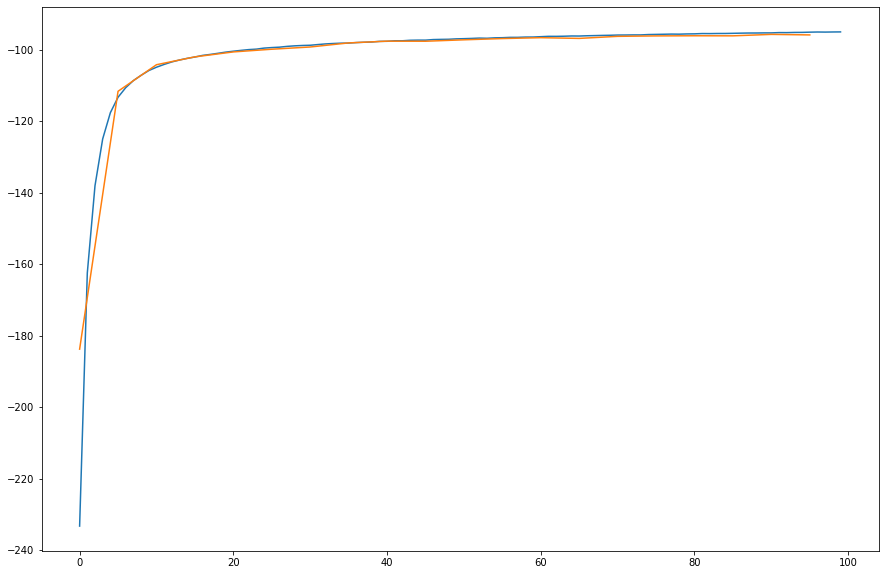

In [17]:
plt.figure(figsize=(15,10))
axe = np.arange(len(train_elbo))
plt.plot(axe, train_elbo)
plt.plot(axe[::5], test_elbo)
plt.show()

In [28]:
tmp = next(iter(test_loader))[0]

In [30]:
tmp[:100]

torch.Size([100, 1, 28, 28])

In [32]:
rec = vae.reconstruct_img(tmp[:100].cuda())

In [45]:
rec = vae.decoder(torch.randn((100,50)).cuda())

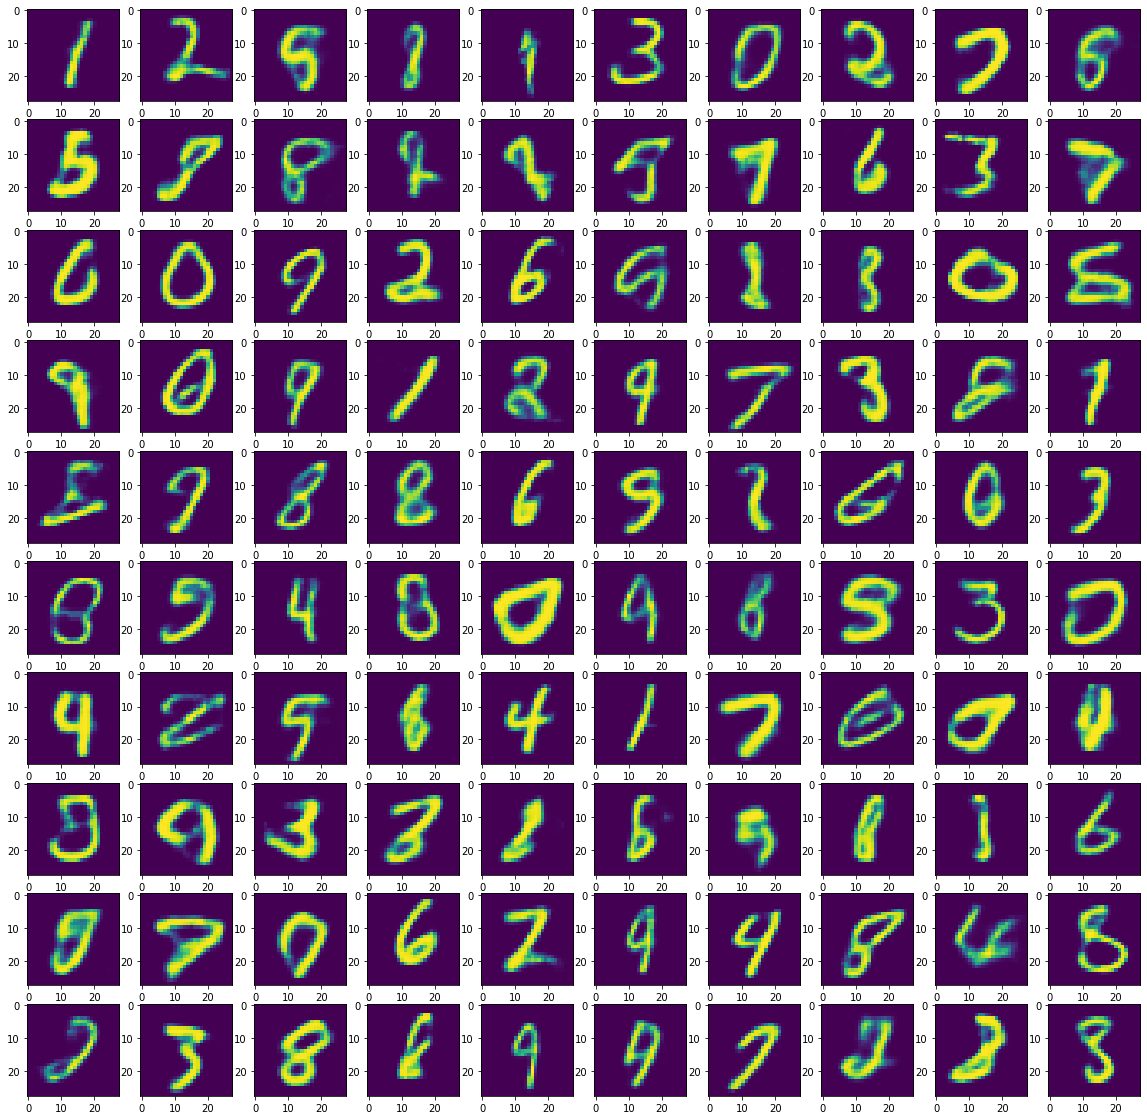

In [46]:
fig,ax = plt.subplots(10,10, figsize=(20,20))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(rec[i*10+j].cpu().detach().numpy().reshape(28,28))
        
plt.show()

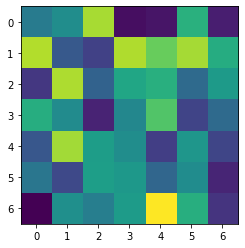

In [51]:
plt.figure()
plt.imshow(np.random.randn(7,7))
plt.show()

In [54]:
#torch.save(vae.state_dict(), "Z:\Tex Diplomka Obrázky\VAE_with_Pyro_MNIST_state_dict.pt")